## Libraries requirements
torch==1.10.0   
torchvision==0.11.1   
numpy==1.21.0   
Pillow==8.2.0   
matplotlib==3.4.3   
tensorflow==2.7.0   
mlflow==1.20.1   
tqdm==4.62.2   

In [1]:
#!pip install tensorrt

In [2]:
import argparse
import os
import copy
import numpy as np
# import PIL.Image as pil_image
from PIL import Image
import matplotlib. pyplot as plt 
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
import torchvision.transforms as T
# import torchvision.transforms as transforms
import time
import tensorflow as tf
import mlflow
import mlflow.tensorflow
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from PIL import Image

2024-10-14 01:01:43.913079: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 01:01:43.974809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 01:01:45.464129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Model 
The `FSRCNN` class implements a deep neural network architecture designed for super-resolution tasks, where the goal is to increase the resolution of an image while preserving its quality. 
The network consists of multiple convolutional layers with different kernel sizes and activation functions, organized into distinct stages:

1. Feature extraction: Extracts low-level features from the input image.
2. Shrinking: Reduces the dimensionality of the feature maps.
3. Non-linear mapping: Applies non-linear transformations to capture complex relationships in the features.
4. Expanding: Increases the dimensionality of the feature maps.
5. Deconvolution: Upscales the image to the desired resolution.

This architecture allows the network to learn effective representations of the image and reconstruct a higher-resolution version that maintains the original content and details.

Note: Mode is not registered for publishing

In [3]:
#class in PyTorch, making it a neural network module
class FSRCNN(nn.Module):
#Initialization
    def __init__(self, scale_factor):

        super(FSRCNN, self).__init__()
        self.scale_factor = scale_factor
        
#sef* lcreate sequential layers of convolutional and activation operations, 
#each serving a specific purpose in the network architecture.
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 56, kernel_size=5, padding=2),
            nn.PReLU()
        )
        self.shrinking = nn.Sequential(
            nn.Conv2d(56, 12, kernel_size=1),
            nn.PReLU()
        )
        self.non_linear_mapping = nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU()
        )
        self.expanding = nn.Sequential(
            nn.Conv2d(12, 56, kernel_size=1),
            nn.PReLU()
        )
        self.deconvolution = nn.ConvTranspose2d(56, 3, kernel_size=9, stride=scale_factor, padding=4, output_padding=scale_factor-1)

#Foward Pass
    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.shrinking(x)
        x = self.non_linear_mapping(x)
        x = self.expanding(x)
        x = self.deconvolution(x)
        return x


# Dataloader / Preprocessing
This section creates a custom dataset class specifically for the `DIV2K` dataset used in super-resolution tasks.     
It loads HR images, resizes them to the desired dimensions, creates corresponding LR images by downscaling, applies optional transformations,     
and returns both images as tensors suitable for training or evaluating a super-resolution model.

In [4]:
#This section makes it a custom dataset class that can be used with PyTorch's data loaders for training or evaluating models.
class DIV2KDataset(Dataset):
    def __init__(self, img_dir, scale_factor, desired_height, desired_width):
        super(DIV2KDataset, self).__init__()
        self.img_dir = img_dir
        self.scale_factor = scale_factor
        self.desired_height = desired_height
        self.desired_width = desired_width
        self.img_list = os.listdir(self.img_dir)
        
#Initialization
    def __getitem__(self, index):
        img_hr = Image.open(os.path.join(self.img_dir, self.img_list[index]))

        # Resize image HR for desired size
        img_hr = img_hr.resize((self.desired_width, self.desired_height), Image.BICUBIC)

        # Redimensionar imagem LR correspondente com o fator de escala
        img_lr = img_hr.resize((self.desired_width // self.scale_factor, self.desired_height // self.scale_factor), Image.BICUBIC)

        transform = T.Compose([
            # Apply need transformations
            T.ToTensor(),
            # Additional tranformations 
        ])

        img_hr = transform(img_hr)
        img_lr = transform(img_lr)

        return img_hr, img_lr
        
#Determining the size of the dataset
    def __len__(self):
        return len(self.img_list)


# Train and Validation
This section initialize train function and validate function 

In [5]:
#Define scale factor (e.g., 3 for upscaling by 3x)
scale_factor = 3

class TrainFSRCNN(object):

#Initialization
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, n_epochs, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.n_epochs = n_epochs
        self.device = device
        self.log_dir = '/phoenix/tensorboard/' #Internal AI Studio log directory for tensorboard
        self.mlflow_exp_name = 'phoenix/mlflow/' #Internal AI Studio log directory for MLFlow
        self.tb_writer = torch.utils.tensorboard.SummaryWriter()
        self.best_metric = float('inf')  # Use 'inf' to minimized metrics & to maximaze use float('-inf')
        self.best_epoch = -1

#Train Function
    def train(self):
        # Add time to calculat training time
        start_time = time.time()

        writer = SummaryWriter(self.log_dir)
        mlflow.set_experiment(self.mlflow_exp_name)

        self.model = self.model.to(self.device)
        self.model.train()

        outer_loop = tqdm(range(self.n_epochs))

        for epoch in outer_loop:
        # for epoch in range(self.n_epochs):
            running_loss = 0.0
            outer_loop.set_description(f"Epoch [{epoch}/{self.n_epochs}]")
            for i, (hr, lr) in enumerate(self.train_loader):
                hr = hr.to(self.device)
                lr = lr.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(lr)
                loss = self.criterion(outputs, hr)

                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            # if (epoch +  1) % 10 == 0:
            if epoch == 1:
                # each 10 epoch:
                # escrever no tensorboard
                self.log_images_to_tensorboard(writer, epoch)

            # Set of validation
            val_loss, val_psnr = self.validate()

            # Printing stats
            print("Epoch: %d, Loss: %.3f, Validation Loss: %.3f, Validation PSNR: %.2f" %
                  (epoch + 1, running_loss / len(self.train_loader), val_loss, val_psnr))
            
            if running_loss < best_metric:
                torch.save(self.model.state_dict(), 'best_model.pth')
                best_metric = running_loss

        writer.close()

        with mlflow.start_run(run_name=self.run_name) as run:
            print(run.info.run_id)
            mlflow.log_metric("Training RMSE", running_loss)
            mlflow.log_metric("Validation RMSE", val_loss)
            mlflow.log_metric("Validation PSNR", val_psnr)
            #mlflow.pytorch.log_model(self.model, "fscnn")
            mlflow.register_model(model_uri = f"runs:/{run.info.run_id}/fscnn", name="fscnn")

        # Adding timer
        end_time = time.time()
        total_time = end_time - start_time
        print('Total time of training: {:.2f} seconds'.format(total_time))

    def log_images_to_tensorboard(self, writer, epoch):
        self.model.eval()

        with torch.no_grad():
            # Get a batch from the validation set
            hr, lr = next(iter(self.val_loader))
            hr = hr.to(self.device)
            lr = lr.to(self.device)

            # Forward pass
            outputs = self.model(lr)

            # Convert images to a grid for visualization
            grid_hr = make_grid(hr, nrow=1, normalize=True)
            grid_lr = make_grid(lr, nrow=1, normalize=True)
            grid_sr = make_grid(outputs, nrow=1, normalize=True)

            # Log images to TensorBoard
            writer.add_image(f'Original/Epoch_{epoch + 1}', grid_hr.permute(2, 0, 1), epoch)
            writer.add_image(f'Low Resolution/Epoch_{epoch + 1}', grid_lr.permute(2, 0, 1), epoch)
            writer.add_image(f'Super-Resolved/Epoch_{epoch + 1}', grid_sr.permute(2, 0, 1), epoch)

#Validate Function
    def validate(self):
        self.model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_psnr = 0.0
            val_loop = tqdm(self.val_loader)
            for i, (hr, lr) in self.val_loader:
                hr = hr.to(self.device)
                lr = lr.to(self.device)
                outputs = self.model(lr)
                loss = self.criterion(outputs, hr)
                val_loss += loss.item()

                # Calcular PSNR - Peak Signal-to-Noise Ratio
                mse = torch.mean((hr - outputs) ** 2) #Calculate Mean Squared Error (MSE):
                psnr = 20 * torch.log10(1.0 / torch.sqrt(mse)) # Calc Peak Signal-to-Noise Ratio
                val_psnr += psnr.item()
                val_loop.set_description(f"Validation: Loss = {val_loss / (i + 1)}")
            val_loop.close()
            return val_loss / len(self.val_loader), val_psnr / len(self.val_loader)
        
    def device_validate(self):
        self.model = self.model.to(self.device)
        return self.validate()

#Create an instance of model
model = FSRCNN(scale_factor)

#why *.pt file? --highly efficient for storing and loading PyTorch objects, making them ideal for large models and datasets
torch.save(model.state_dict(), 'FSRCNN_300_epochs.pt')

The section below sets up the necessary configuration parameters, selects the device for training, initializes the MLflow experiment, and loads the training and validation datasets using the `DIV2KDataset` class.        
These components are essential for training the FSRCNN model using the previously defined `TrainFSRCNN` class.

In [6]:
class Args:
    train_dir = 'train/'
    val_dir = 'valid/'
    scale = 4
    batch_size = 4
    epochs = 300

args = Args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

mlflow.set_experiment("Resolution 4x")

# Load dataset train
train_dataset = DIV2KDataset(args.train_dir, args.scale, 1020, 2040)

# Load dataset for validation
val_dataset = DIV2KDataset(args.train_dir, args.scale, 1020, 2040)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)

cuda


 Inference     
torch.save(model.state_dict(), 'FSRCNN_300_epochs.pt')     
Moved to Model section 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This code snippet loads a pre-trained FSRCNN model, retrieves a validation image batch, performs super-resolution prediction on the low-resolution image, and visualizes both the original high-resolution image and the predicted high-resolution image side-by-side, allowing you to compare the model's output with the ground truth. 
This helps you evaluate the model's performance qualitatively.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image Loss torch.Size([3, 1020, 2040])
image HR torch.Size([3, 1020, 2040])


(-0.5, 2039.5, 1019.5, -0.5)

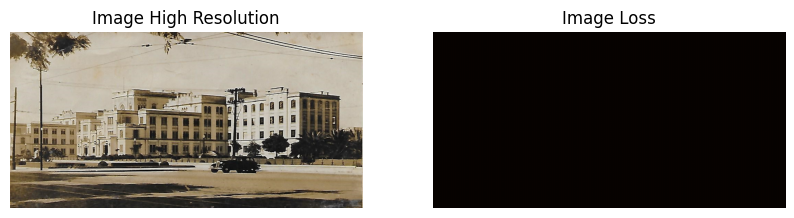

In [7]:
#set up GPU, note for this project AI Studio was configure with a GPU enable custom workspace
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Loading models
model = FSRCNN(4)
model.to(device)
model.load_state_dict(torch.load('FSRCNN_300_epochs.pt'))
model.eval()

class Args:
    train_dir = 'train/'
    val_dir = 'valid/' 
    scale = 4
    batch_size = 4
    epochs = 300

#Dataset Configuration
args = Args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset train
train_dataset = DIV2KDataset(args.train_dir, args.scale, 1020, 2040)

# Load dataset for validation
val_dataset = DIV2KDataset(args.val_dir, args.scale, 1020, 2040)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)

# hr_img, lr_img
x_batch, y_batch = next(iter(val_loader))
y, x = x_batch[0], y_batch[0]
x = x.to(device)

#Prediction
pred = model(x)

#Result Processing and Visualization
pred = pred.cpu()
print('image Loss', pred.shape)
print('image HR', y.shape)

# Convert tensores to arrays numpy
y = y.numpy().transpose(1, 2, 0)
pred = pred.detach().numpy().transpose(1, 2, 0)

# Plot images 
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(y)
axes[0].set_title('Image High Resolution')
axes[0].axis('off')

axes[1].imshow(pred)
axes[1].set_title('Image Loss')
axes[1].axis('off')

# HR and LR image comparison
The purpose of these functions is to provide a visual representation of the images contained within the training and validation datasets.  
This can be helpful for understanding the characteristics of the data, such as image size, content, and distribution. 
It can also be used to identify potential issues or discrepancies in the data that might affect the model's training or performance.   
By executing these functions, you can visualize images from the training and validation datasets to gain insights into their content and characteristics.

image HR torch.Size([1020, 2040, 3])
image LR torch.Size([255, 510, 3])


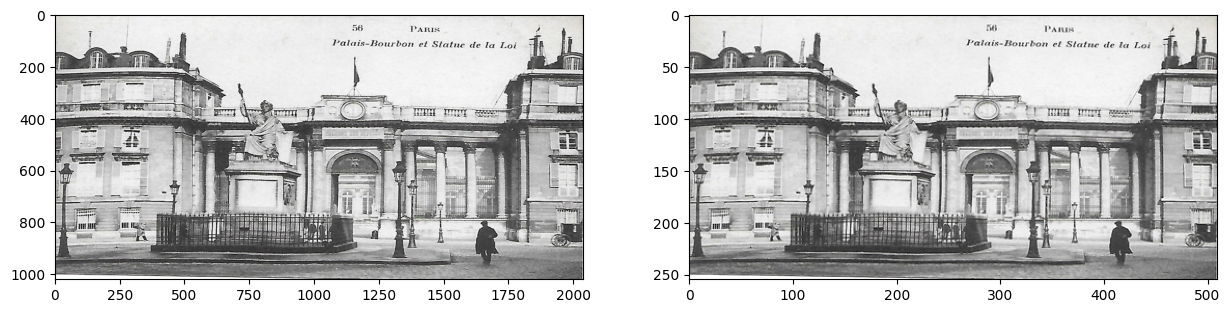

In [8]:
def train_imgs_visualization():

#This function is designed to visualize a images from the train directory    
    for imgs in train_loader:
        fig = plt.figure(figsize=(15, 10)) # Changed from (10, 7)

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        print('image HR', img1.shape)

        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        print('image LR', img2.shape)
        break

#This function is designed to visualize a images from the validation directory
def val_imgs_visualization():
    for imgs in val_loader:
        fig = plt.figure(figsize=(15, 10)) # Changed from (10, 7)

#To rearrange the dimensions of the images from the PyTorch tensor format (channels, height, width) to the format expected 
#by `plt.imshow` (height, width, channels).
        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)

        # Save the image in current directory
        image.save("img1.png")

        # Load an image
        image = Image.open("img1.png")
        
        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        break

train_imgs_visualization()
#Note that increasing the size of the image was not recommended 

In [9]:
#no need for tensorboard
#mad mad elevator pitch
#the thought process to end result
#visual - images enlarge images 
#explort image to secondary file 

## References Git
Jaiaid
https://github.com/pytorch/examples/blob/main/imagenet/main.py 

Lornatag
https://github.com/Lornatang/FSRCNN-PyTorch/blob/master/model.py 

Colleagues      
Rafael Borges        
ML Engineer and Data Scientist – HP Brazil     
https://www.linkedin.com/in/rafa-borges/

Morgana Dias Rodrigues      
Data Scientist - Teais Labs     
https://www.linkedin.com/in/morgana-dias-rodrigues/
